In [92]:
# Framework:
#
# 1. Individual stock:
#      ---- GENERAL INPUT: only one sticker
#   1.1. Parameter estimates:
#      - plot_1: mean (2/5/10 years rolling windows in one plot)
#      - plot_2: volatility (2/5/10 years rolling windows in one plot)
#   1.2. VaR/ES
#      - input: VaR prob, ES prob, rolling windows*, horizon, method**
#      - plot: VaR and ES in one plot
# 2. Portfolio: (portfolio lognormal/position normal)
#      ---- GENERAL INPUT: stickers, initial investment, weights
#   2.1. Parameter estimates:
#      - plot_1: mean (2/5/10 years rolling windows in one plot)
#      - plot_2: volatility (2/5/10 years rolling windows in one plot)
#   2.2. VaR/ES (ASSUMPTION: portfolio following GBM)
#      - input: VaR prob, ES prob, rolling window*, horizon, method**
#      - plot: VaR and ES in one plot
#
#    * choose from 2/5/10 because parameters already computed above
#   ** choose from historical/parametric/MC
#  *** historical method: assumes relative price changes (log returns)
#      parametric/MC methods: assumes portfolio follow GBM

In [ ]:
# TODO:
#
# 1. Portfolio parameters (hw6)
# 2. Portfolio VaR/ES (hw6)
# 3. Historical method (hw7)
# 4. Monte Carlo (hw8)
# 5. Plot

In [1]:
# import packages

import pandas_datareader.data as web
import datetime
import pandas as pd
import numpy as np
import scipy.stats as stat
import dateutil.relativedelta
import matplotlib.pyplot as plt

from __future__ import division

In [ ]:
##########################################################################################
############################ PART 1: STOCK ANALYSIS ######################################
##########################################################################################

In [31]:
# Set up input

position_date_1 = datetime.datetime(2010, 12, 1)   # first day of plot
end_date_1 = datetime.datetime(2016, 12, 1)        # pick up a date for testing, may remove later and set today as default
ticker_1 = "AAPL"                                  # Stock ticker (string)

# VaR/ES input
v0_1 = 10000                                         # initial investment
VaR_prob_1 = 0.99
ES_prob_1 = 0.975
window_1 = 2                                         # using 2 years historical data for estimation
horizon_days_1 = 5                                   # 5 days VaR/ES

# Not input, prepared for further analysis
window_days_1 = window_1 * 252                         # convert to days
horizon_1 = horizon_days_1/252                         # convert to years
start_date_1 = position_date_1 - dateutil.relativedelta.relativedelta(years = 10)      # fetch data starting from start_date
price_1 = web.DataReader(ticker_1, 'yahoo', start_date_1, end_date_1)['Adj Close'].sort_index(ascending = False)   

In [32]:
# Calculate estimated parameters for GBM based on x year (in days) rolling windows
def gbm_est(prices, window_days):
    rtn = -np.diff(np.log(prices))
    rtnsq = rtn * rtn
    mubar = list(reversed(np.convolve(rtn, np.ones((window_days,))/window_days, mode='valid')))
    x2bar = list(reversed(np.convolve(rtnsq, np.ones((window_days,))/window_days, mode='valid')))
    var = x2bar - np.square(mubar)
    sigmabar = np.sqrt(np.maximum(var, np.zeros(len(var))))
    sigma = sigmabar / np.sqrt(1/252)
    mu = np.array(mubar)*252 + np.square(sigma)/2
    return rtn, mu, sigma, np.array(mubar), sigmabar

In [33]:
# test with AAPL 
rtn_12, mu_12, sigma_12, mubar_12, sigmabar_12 = gbm_est(price_1, 2*252)
rtn_15, mu_15, sigma_15, mubar_15, sigmabar_15 = gbm_est(price_1, 5*252)
rtn_110, mu_110, sigma_110, mubar_110, sigmabar_110 = gbm_est(price_1, 10*252)

In [34]:
rtn_12   # compare with values computed in Matlab

array([-0.00936327, -0.0084693 , -0.00098642, ..., -0.17208061,
        0.01855391, -0.02222338])

In [35]:
mu_12   # compare with values computed in Matlab

array([ 0.0912205 ,  0.12017773,  0.11768592, ...,  0.01951603,
        0.03152471,  0.02877686])

In [45]:
sigma_12   # compare with values computed in Matlab

array([ 0.57278381,  0.57312372,  0.57305406, ...,  0.25495355,
        0.25395576,  0.25402751])

In [46]:
mu_15   # compare with values computed in Matlab

array([ 0.54276587,  0.54782728,  0.5456464 , ...,  0.20579393,
        0.19721042,  0.19689942])

In [47]:
sigma_15   # compare with values computed in Matlab

array([ 0.47007218,  0.46995073,  0.46989827, ...,  0.26228784,
        0.26189725,  0.26190831])

In [48]:
mu_110   # compare with values computed in Matlab

array([ 0.45914206,  0.46168227,  0.45938395, ...,  0.2782567 ,
        0.27969277,  0.27622896])

In [49]:
sigma_110   # compare with values computed in Matlab

array([ 0.43933745,  0.43927416,  0.43924459, ...,  0.33086901,
        0.33079546,  0.33072318])

In [98]:
length = min(len(mu_12), len(mu_15), len(mu_110), len(sigma_12), len(sigma_15), len(sigma_110))
mu = pd.DataFrame({'Mu_2': mu_12[:length], 'Mu_5': mu_15[:length], 'Mu_10': mu_110[:length]}, 
                  index = price_1.index[:length])
sigma = pd.DataFrame({'Sigma_2': sigma_12[:length], 'Sigma_5': sigma_15[:length], 'Sigma_10': sigma_110[:length]},
                    index = price_1.index[:length])
#p = pd.DataFrame(data = mu_12, index = price_1.index)
# plt.plot(price_1.index,sigma_12)

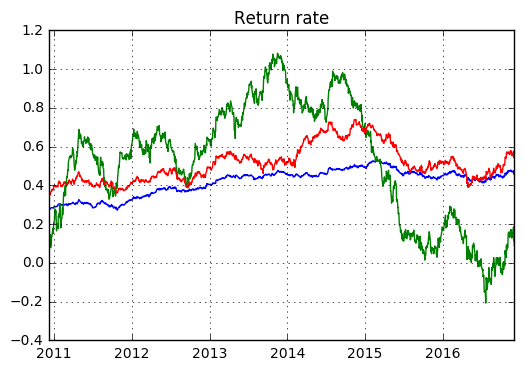

In [111]:
# TODO:
#   - define in a method
#   - legend
#   - can plot mu and sigma in different methods
#   - fancy!!!!!!

plt.plot(mu)
plt.grid(True)
plt.title('Return rate')
# plt.show()
plt.plot(sigma)
plt.grid(True)
plt.title('Return rate')
# plt.show()

In [50]:
# Calculate t-day VaR with confidence degree p assuming gbm, --parametric method
# Using parameter estimated above 
def gbm_VaR(v0, mu, sigma, p, t):
    VaR = v0 - v0 * np.exp(sigma * np.sqrt(t) * stat.norm.ppf(1-p) + (mu - np.square(sigma)/2) * t)
    return VaR

In [53]:
VaR_12 = gbm_VaR(v0_1, mu_12, sigma_12, VaR_prob_1, horizon_1)
VaR_15 = gbm_VaR(v0_1, mu_15, sigma_15, VaR_prob_1, horizon_1)
VaR_110 = gbm_VaR(v0_1, mu_110, sigma_110, VaR_prob_1, horizon_1)

In [54]:
VaR_12   # compare with values computed in Matlab

array([ 1723.2832322 ,  1719.4808539 ,  1719.69467144, ...,   803.87256717,
         798.62680794,   799.34812896])

In [55]:
VaR_15   # compare with values computed in Matlab

array([ 1353.75166064,  1352.52936965,  1352.75068763, ...,   792.3241649 ,
         792.69510665,   792.78580512])

In [56]:
VaR_110   # compare with values computed in Matlab

array([ 1278.29305978,  1277.66775266,  1277.97874878, ...,   987.62631049,
         987.14794838,   987.54960425])

In [58]:
# Calculate t-day ES with confidence degree p assuming gbm, --parametric method\
# Using parameter estimated above 
def gbm_ES(v0, mu, sigma, p, t):
    ES = v0 * (1 - np.array(stat.norm.cdf(stat.norm.ppf(1-p) - np.sqrt(t)*sigma)) * np.array(np.exp(mu*t)/(1-p)))
    return ES

In [59]:
ES_12 = gbm_ES(v0_1, mu_12, sigma_12, ES_prob_1, horizon_1)
ES_15 = gbm_ES(v0_1, mu_15, sigma_15, ES_prob_1, horizon_1)
ES_110 = gbm_ES(v0_1, mu_110, sigma_110, ES_prob_1, horizon_1)

In [60]:
ES_12   # compare with values computed in Matlab

array([ 1727.83150326,  1724.03209912,  1724.24561802, ...,   806.96742872,
         801.71398268,   802.43574208])

In [61]:
ES_15   # compare with values computed in Matlab

array([ 1358.12207209,  1356.89982799,  1357.12078745, ...,   795.49179998,
         795.85897408,   795.94974445])

In [62]:
ES_110   # compare with values computed in Matlab

array([ 1282.54671021,  1281.92137   ,  1282.23205653, ...,   991.30403569,
         990.82530106,   991.22623501])

In [ ]:
##########################################################################################
######################## PART 2: PORTFOLIO ANALYSIS ######################################
##########################################################################################

In [ ]:
# PART 2: portfolio analysis
# Setting up input

position_date_2 
end_date_2
v0 = 10000   # initial investment
tickers_string = "AAPL,AMZN"   # a string; as an example, tickers separated by comma.
tickers_list = tickers_string.split(",")  # split the string by the commas into a list of strings
weight_string = "0.5,0.5"
weight_list = map(float, weight_string.split(","))  
    # split the string by the commas, and map each string in the resulting list into a float

In [86]:
d={}
for ticker in tickers_list:
    d["{0}".format(ticker)] = web.DataReader(ticker, 'yahoo', start_date, end_date)['Adj Close'].rename(ticker)
df = pd.DataFrame(d).sort_index(ascending = False)       
# create a pandas dataframe where each column is the Adjusted Close price for the respective ticker

In [ ]:
df['AAPL'][position_date]

In [89]:
shares = np.round(np.divide(v0 * np.array(weight_list), np.array(df.ix[position_date])))

In [90]:
shares

array([ 121.,   28.])